In [1]:
# [1] Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import os
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


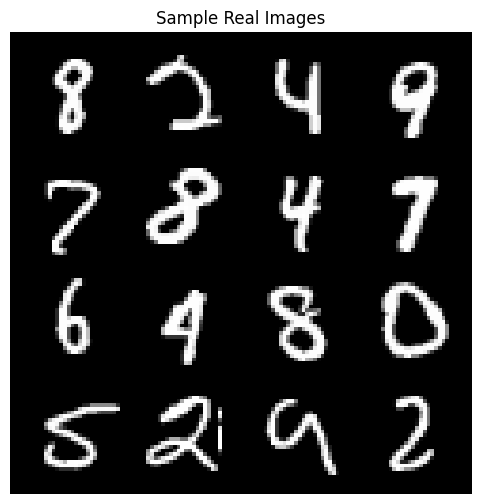

In [2]:
# [2] Data Loading and Preprocessing (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

batch_size = 128
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Show some samples
examples = next(iter(train_loader))
images = examples[0][:16]
grid = make_grid(images, nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title("Sample Real Images")
plt.axis("off")
plt.show()


In [3]:
# [3] Define Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

G = Generator().to(device)
summary(G, (100,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 512]         131,584
         LeakyReLU-4                  [-1, 512]               0
            Linear-5                 [-1, 1024]         525,312
         LeakyReLU-6                 [-1, 1024]               0
            Linear-7                  [-1, 784]         803,600
              Tanh-8                  [-1, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.67
Estimated Total Size (MB): 5.71
----------------------------------------------------------------


In [4]:
# [4] Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

D = Discriminator().to(device)
summary(D, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
         LeakyReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                    [-1, 1]             257
           Sigmoid-9                    [-1, 1]               0
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
-------------------------------------------

In [ ]:
# [5] Loss, Optimizers, Training Loop
criterion = nn.BCELoss()
lr = 0.0002
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)
epochs = 100
noise_dim = 100

losses_G = []
losses_D = []

for epoch in range(epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs_real = D(real_imgs)
        d_loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(noise)
        outputs_fake = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(noise)
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    losses_G.append(g_loss_epoch / len(train_loader))
    losses_D.append(d_loss_epoch / len(train_loader))

    print(f"Epoch {epoch+1}/{epochs} | Generator Loss: {losses_G[-1]:.4f} | Discriminator Loss: {losses_D[-1]:.4f}")


Epoch 1/100 | Generator Loss: 4.0269 | Discriminator Loss: 0.4254
Epoch 2/100 | Generator Loss: 6.3667 | Discriminator Loss: 0.3171
Epoch 3/100 | Generator Loss: 5.5130 | Discriminator Loss: 0.3857
Epoch 4/100 | Generator Loss: 6.1385 | Discriminator Loss: 0.3609
Epoch 5/100 | Generator Loss: 3.3001 | Discriminator Loss: 0.6628
Epoch 6/100 | Generator Loss: 2.3208 | Discriminator Loss: 0.6767
Epoch 7/100 | Generator Loss: 3.3544 | Discriminator Loss: 0.3970
Epoch 8/100 | Generator Loss: 3.1442 | Discriminator Loss: 0.5384
Epoch 9/100 | Generator Loss: 2.9012 | Discriminator Loss: 0.5782
Epoch 10/100 | Generator Loss: 2.6846 | Discriminator Loss: 0.5896
Epoch 11/100 | Generator Loss: 2.6860 | Discriminator Loss: 0.6527
Epoch 12/100 | Generator Loss: 2.5808 | Discriminator Loss: 0.6823
Epoch 13/100 | Generator Loss: 2.4030 | Discriminator Loss: 0.7089
Epoch 14/100 | Generator Loss: 2.2287 | Discriminator Loss: 0.7575
Epoch 15/100 | Generator Loss: 2.1164 | Discriminator Loss: 0.7738
Epoc

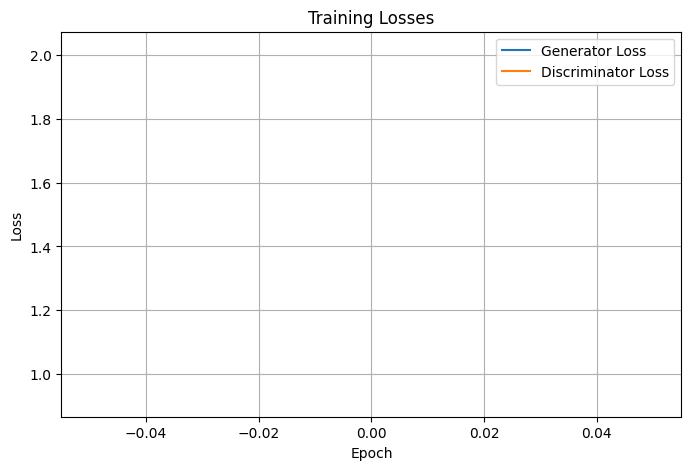

In [ ]:
# [6] Plot Generator and Discriminator Loss
plt.figure(figsize=(8, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


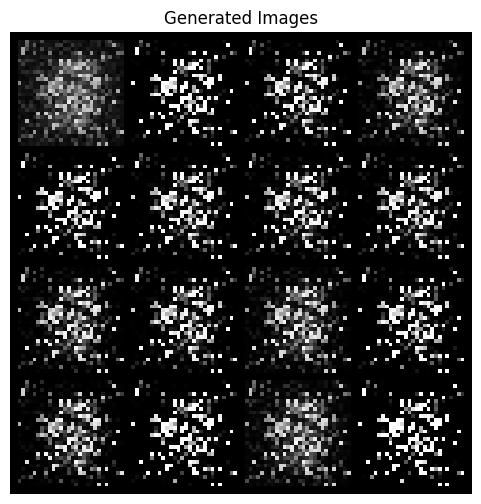

In [ ]:
# [7] Generate and Show Images from Generator
noise = torch.randn(16, noise_dim).to(device)
generated_imgs = G(noise).detach().cpu()
grid = make_grid(generated_imgs, nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Generated Images")
plt.axis("off")
plt.show()


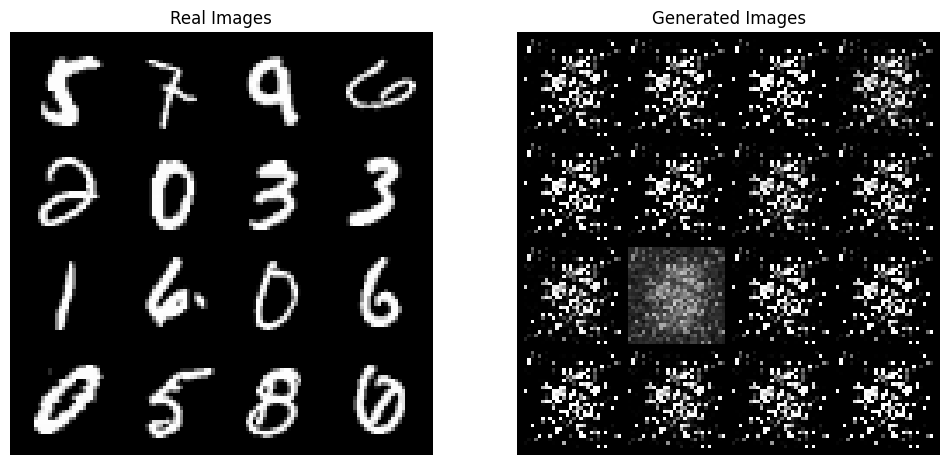

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Get a batch of real images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:16].to(device)  # take first 16 images

# Generate fake images
noise = torch.randn(16, noise_dim).to(device)
fake_imgs = G(noise).detach().cpu()

# Move real images to CPU for plotting
real_imgs = real_imgs.cpu()

# Create image grids
real_grid = make_grid(real_imgs, nrow=4, normalize=True)
fake_grid = make_grid(fake_imgs, nrow=4, normalize=True)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Real images
axs[0].imshow(real_grid.permute(1, 2, 0))
axs[0].set_title("Real Images")
axs[0].axis("off")

# Fake images
axs[1].imshow(fake_grid.permute(1, 2, 0))
axs[1].set_title("Generated Images")
axs[1].axis("off")

plt.show()
